In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import re

import matplotlib.pyplot as plt
import numpy as np
import pickle
from ray import tune
import torch

from genome_embeddings import trainable # import before ray (?)
import ray

In [3]:
settings = Namespace(
    DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
    #/home/ndudek/projects/def-dprecup/ndudek/
    SAVE_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/',
    #/home/ndudek/projects/def-dprecup/ndudek/
    num_epochs = 2,
    num_cpus=5, 
    replacement_threshold = 0.5, # probability over which binarizer converts to a 1
    num_corruptions = 100, # number of corrupted versions of a genome to produce
)

# Load data

In [4]:
## Figure out which genomes I want to include in my dataset
# Use phylogenetically thinned list in selected_genomes.txt AND filter out non-bacteria
path = "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/selected_kegg.txt"
file = open(path).readlines()
file = list(map(str.strip, file))

# The keepers list ends up having a few genomes that do not get used
# This is bc they have no full modules
keepers = [] 
# Create dict that converts tla (e.g.: Pea) -> t_num (e.g.: T321890)
tla_to_tnum = {}

line_counter = 0
for s in file:
    if line_counter < 4:
        line_counter += 1
        continue
    tla = s.split()[1]
    t_num = s.split()[2]
    tax = s.split()[3]
    
    if "k__Bacteria" in tax:
        keepers.append(t_num)
        tla_to_tnum[tla] = t_num

print("Total number of bacterial genomes in dataset: {}".format(len(keepers)))

In [5]:
### load each genome as a list of KOs
path = "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/annotations/annotations_list.txt"
master_file = open(path).readlines()
master_file = list(map(str.strip, master_file))

### Create dict mapping genomes to encoded KOs
# key = t_num 
# ko = list of all KOs annotated in genome
org_to_kos = {}
for i in master_file:
    file = open("/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/annotations/"+i).readlines()
    file = list(map(str.strip, file))
    
    org = i.split("_")[0]
    
    try:
        t_num = tla_to_tnum[org]
    except KeyError: continue # phylogenetically thinned set, not all will be present in dict (e.g. "Pea")
    #if t_num not in keepers: continue
    
    kos = []
    for s in file:
        if "<a href=" in s:
            x = s.split()[2]
            if re.match(r'[K]\d{5}', x): 
                kos.append(x) #[K]\d{5}
                
    org_to_kos[t_num] = kos   

# Data exploration

In [6]:
# Create unique list of all KOs (all_kos) 
all_kos = []
for t_num in org_to_kos:
    all_kos.extend(org_to_kos[t_num])
all_kos = list(set(all_kos))
n_kos_tot = (len(all_kos))
print("Total number of KOs in dataset: {}".format(n_kos_tot))

In [7]:
# Load mapping from organism (tla, e.g.: Pea) to complete modules encoded to KOs in each module
with open('/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/org_to_mod_to_kos.pkl', 'rb') as f:
    org_to_mod_to_kos = pickle.load(f)

In [8]:
# Create dict: mod_sets
# For each module, have a counter (dict) of each unique string of KOs that can make up the module + # occurences 
# mod_sets['M00001'] = {'K00001_K04398': 5, 'K00002_K23456': 10}
mod_sets = defaultdict(lambda: defaultdict(int))
for org in org_to_mod_to_kos:
    for mod in org_to_mod_to_kos[org]:
        ko_str = "_".join(org_to_mod_to_kos[org][mod])
        mod_sets[mod][ko_str] += 1

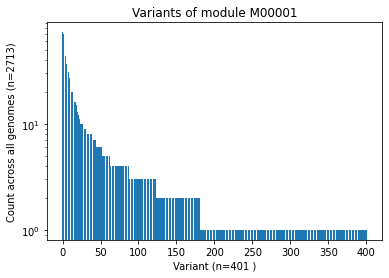

In [9]:
mod = 'M00001'
a = list(mod_sets[mod].values())
a.sort(reverse=True)
x_labels = [i for i in range(len(mod_sets[mod].values()))]
plt.bar(x_labels, a)
plt.yscale('log')
plt.title("Variants of module "+mod)
plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
plt.ylabel("Count across all genomes (n="+str(len(org_to_mod_to_kos))+")")
print(max(mod_sets[mod].values()), len(a))

In [10]:
# Select most "popular" version of each module, store it in dict: mod_to_ko_clean
# mod_to_ko_clean['M00003'] = ['K00001', 'K00002', etc] <- most common variant of M00003
mod_to_ko_clean = {}
for mod in mod_sets:
    max_count = 0
    max_path = ""
    for ko_str in mod_sets[mod]:
        if mod_sets[mod][ko_str] > max_count: # if there is a tie, the first one is kept 
            max_count = mod_sets[mod][ko_str]
            max_path = ko_str.split("_")
    mod_to_ko_clean[mod] = max_path

## Data exploration

In [11]:
all_kos2 = []
for org in org_to_mod_to_kos:
    for mod in org_to_mod_to_kos[org]:
        all_kos2.extend(org_to_mod_to_kos[org][mod])
all_kos2 = list(set(all_kos2))        

In [12]:
for ko in all_kos2:
    if ko not in all_kos:
        print(ko)

Text(0.5, 1.0, 'Distribution of the # of modules (n=252) per genome (n=2713)')

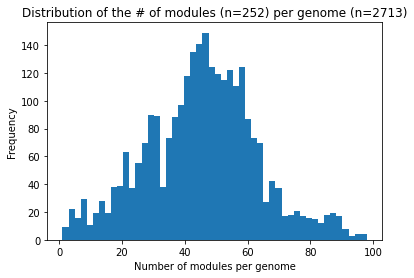

In [13]:
# Plot the number of modules encoded by each genome
n_genomes = len(org_to_mod_to_kos)
temp = [list(org_to_mod_to_kos[i].keys()) for i in org_to_mod_to_kos]
n_mods = len(list(set([item for sublist in temp for item in sublist])))
plt.hist([len(org_to_mod_to_kos[i]) for i in org_to_mod_to_kos], 50)
plt.xlabel("Number of modules per genome")
plt.ylabel("Frequency")
plt.title("Distribution of the # of modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")

In [14]:
a = [len(org_to_mod_to_kos[org]) for org in org_to_mod_to_kos]
a.sort()
print("There are "+str(a.count(0))+" genomes with zero modules")

# Red
# Rue
# pvac
# cgw

In [15]:
# NOTE THAT SOME GENOMES DO NOT HAVE A SINGLE MOD AND AREN'T EVEN IN THE DICT (n= 2717-2713 = 5)
# E.G.: clap 

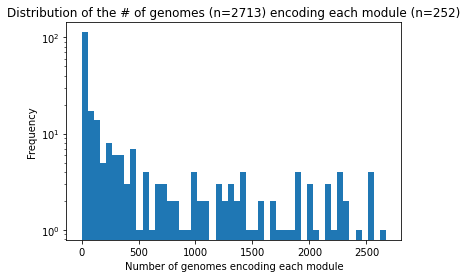

In [16]:
# Count and plot the number of genomes that encode each module
mods_count = defaultdict(int)
for org in org_to_mod_to_kos:
    for mod in org_to_mod_to_kos[org]:
        mods_count[mod] += 1
        
plt.hist(mods_count.values(), 50)
plt.xlabel("Number of genomes encoding each module")
plt.ylabel("Frequency")
plt.title("Distribution of the # of genomes (n="+str(n_genomes)+") encoding each module (n="+str(n_mods)+")")
plt.yscale('log')
print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))

In [17]:
# DO NOT LET INPUT BE SUPER RARE MODS
# NN SHOULD JUST MEMORIZE THAT GENOME

Text(0.5, 1.0, 'Distribution of the % of KOs (n_all=9874) represented by modules (n=252) per genome (n=2713)')

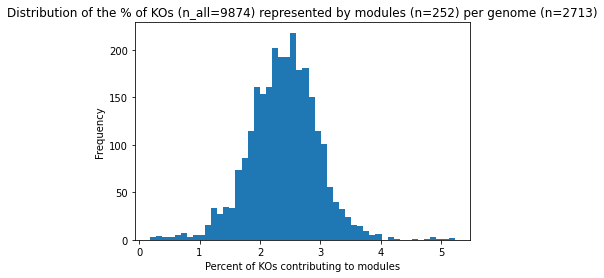

In [18]:
# Plot the percentage of genes per genome that contribute to modules
perc_mod = []
for org in org_to_mod_to_kos:
    try:
        tla = tla_to_tnum[org]
        n_kos = len(org_to_kos[tla])
        n_mod_kos = len([org_to_mod_to_kos[org][mod] for mod in org_to_mod_to_kos[org]])
        perc_mod.append(n_mod_kos/n_kos*100)
    except: KeyError

plt.hist(perc_mod, 50)
plt.xlabel("Percent of KOs contributing to modules")
plt.ylabel("Frequency")
plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [19]:
# Percentage of KOs that are / are not part of a module

kos_in_mods = []

for org in org_to_mod_to_kos:
    for mod in org_to_mod_to_kos[org]:
        kos_in_mods.extend(org_to_mod_to_kos[org][mod])

kos_in_mods = list(set(kos_in_mods))

print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [20]:
# Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
#all_kos # unique list of all KOs
ko_counter = defaultdict(list)

for ko in all_kos:
    for org in org_to_mod_to_kos:
        for mod in org_to_mod_to_kos[org]:
            if ko in org_to_mod_to_kos[org][mod]:
                if mod not in ko_counter[ko]:
                    ko_counter[ko].append(mod)

In [21]:
ko_counter2 = {}
for ko in ko_counter:
    ko_counter2[ko] = len(ko_counter[ko])

for ko in all_kos:
    if ko not in ko_counter2:
        ko_counter2[ko] = 0

In [22]:
a = defaultdict(int)
for i in ko_counter2.values():
    a[i] += 1
a, sum(a.values())

(defaultdict(int,
             {1: 1052, 3: 57, 2: 199, 4: 28, 5: 8, 6: 5, 7: 8, 9: 2, 0: 8515}),
 9874)

Text(0, 0.5, 'Frequency (# of KOs)')

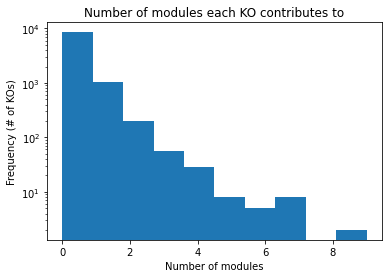

In [23]:
plt.hist(ko_counter2.values())
plt.yscale('log')
plt.title("Number of modules each KO contributes to")
plt.xlabel("Number of modules")
plt.ylabel("Frequency (# of KOs)")

# Data pre-processing

In [24]:
### Make dataframe (rows = genomes, columns = KOs)

# data = np.zeros(shape=(n_genomes,n_kos_tot))

# genome_order = []
# for i, org in enumerate(org_to_mod_to_kos):
#     genome_order.append(org)
#     for j in range(n_kos_tot):
#         try:
#             tla = tla_to_tnum[org]
#             if all_kos[j] in org_to_kos[tla]:
#                 data[i,j] = 1
#             else: pass
#         except:
#             print(i, org, tla, j)
            
# data = torch.tensor(data)
# torch.save(data, "/Users/natasha/Desktop/kegg_v2.pt")
#torch.save(genome_order, "/Users/natasha/Desktop/genome_order.pt")

In [25]:
data = torch.load("/Users/natasha/Desktop/kegg_v2.pt")
genome_order = torch.load("/Users/natasha/Desktop/genome_order.pt")

In [26]:
### Make new taxonomy dict, cluster_names object

In [27]:
### Drop rare KO's?

# Re-create train-test split from before

In [28]:
### Create train-test split (ideally identical to former split)
# Old original split contains euk and arch
import pandas as pd
path = "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/uncorrupted_test_balanced.csv"
test_orig = pd.read_csv(path, index_col=0) 
test_genomes_orig = test_orig.index.to_list()

train_genomes = []
test_genomes = []
for genome in keepers: 
    if genome not in test_genomes_orig:
        train_genomes.append(genome)
    elif genome in test_genomes_orig:
        test_genomes.append(genome)
        
# Expected: train = 2395, test = 288
len(train_genomes), len(test_genomes), len(train_genomes) + len(test_genomes)

(2430, 288, 2718)

In [29]:
def prep_data(list_genomes, all_kos, org_to_kos, mode):
    """
    Creates a tensor for training / test data
    
    Arguments:
    list_genomes (list) -- t_nums to be included in the tensor (i.e. train_genomes or test_genomes)
    all_kos (list) -- all KOs that exist in the dataset
    org_to_kos (dict) -- keys = t_nums, values = list of KOs encoded by genome
    mode (str) -- used to save data to file ["test" | "train"] 
    
    Returns:
    data (np array) -- rows = genomes, columns = KOs, 1 = KO present in genome, 0 = KO absent in genome
    """
    from datetime import date
    
    assert (mode == "test" or mode == "train")
    
    data = np.zeros(shape=(len(list_genomes),len(all_kos)))

    for i, t_num in enumerate(list_genomes): # org is something like 'T03060'
        for j, ko in enumerate(all_kos):
            if ko in org_to_kos[t_num]:
                data[i,j] = 1
            else: pass

    #tensor_data = torch.tensor(tensor_data) 
    torch.save(data, "/Users/natasha/Desktop/kegg_v2_"+mode+"_"+str(date.today())+".pt")
    
    return data

In [30]:
# train_data = prep_data(train_genomes, all_kos, org_to_kos, "train")
# test_data = prep_data(test_genomes, all_kos, org_to_kos, "test")
train_data = torch.load("/Users/natasha/Desktop/kegg_v2_train_2020-09-03.pt")
test_data = torch.load("/Users/natasha/Desktop/kegg_v2_test_2020-09-03.pt")

In [31]:
train_data.shape, test_data.shape

((2430, 9874), (288, 9874))

# New corruption process

In [32]:
# For each genome, keep the KO's in 1-10 modules. Everything else should be zeros

def corrupt(train_data, train_genomes, n_corrupt, tnum_to_tla):
    """
    Creates corrupted + matching uncorrupted tensor of genomes, in that order
    Note: only genomes with >= 1 module are included in the output
    Note: uses "cleaned" modules from mod_to_ko_clean  
        I.e. most common set of KOs per module, rather than 20 variants of each mod
    
    Arguments:
    train_data (tensor) -- rows = uncorrupted genomes, columns = KOs
    train_genomes (list) -- names of genomes in train_data (e.g.: "T03060")
    n_corrupt (int) -- number of corrupted versions to make of each genome
    tnum_to_tla (dict) -- maps tnum (e.g.: "T03060") to tla (e.g.: "Red")
    
    Returns:
    output (tensor) -- corrupted + uncorrupted genomes (each genome's two versions are concatenated in a row)
    c_train_genomes -- names of genomes in the order they appear in output
    """
    
    import random
    
    # For one rep of one genome
    def heart_of_corruption(org, n_max):
        """
        Creates
        
        Arguments:
        org (str) -- tla for genome (e.g.: "aha")
        n_max (int) -- the maximum number of mods to select for corrupted version of any given genome

        """
        n_mods = random.randint(1, n_max) # going to select this many mods for corrupted genome
        keeps = random.sample(list(org_to_mod_to_kos[org].keys()), n_mods)            
        #print(org, keeps)
        idxs = []
        for mod in keeps:
            for ko in org_to_mod_to_kos[org][mod]:
            #for ko in mod_to_ko_clean[mod]:
                idxs.append(all_kos.index(ko))
 
        # create corrupted version of genome that only has those mods
        corrupted = np.zeros(n_kos_tot)
        for i in idxs:
            corrupted[i] = 1

        return corrupted
    
    output = [] 
    c_train_genomes = []
    
    line_counter = 0
    for i, tnum in enumerate(train_genomes):
        org = tnum_to_tla[tnum]
        n_tot_mods = len(org_to_mod_to_kos[org]) # number of modules in the genome 
        n_max = min(n_tot_mods, 10) # which is smaller: the # mods or 10
        
        n_corrupted = 0
        if n_tot_mods >= 1: 
            uncorrupted = train_data[i]
            while n_corrupted < n_corrupt: 
                c_train_genomes.append(org)
                corrupted = heart_of_corruption(org, n_max)
                genome_out = np.concatenate((corrupted, uncorrupted), axis=None)
                output.append(genome_out)
                line_counter += 1
                n_corrupted += 1
            
    return torch.Tensor(np.array(output)), c_train_genomes

In [ ]:
# #mods_to_match = org_to_mod_to_kos[org]
# # USE mod_to_ko_clean


# mods_to_match = org_to_mod_to_kos['eun']

# # for every user-defined input module
# for keep_mod in mods_to_match:
#     ko_count = defaultdict(int)
#     # figure out which orgs have that mod
#     for org2 in org_to_mod_to_kos:
#         if keep_mod in org_to_mod_to_kos[org2]:
#             # if present, add the relevant KOs to the list and start a count of how many genomes they are present in
#             tnum = tla_to_tnum[org2]
#             for ko in org_to_mod_to_kos[org2][keep_mod]:
#             #for ko in mod_to_ko_clean[keep_mod]:
#                 ko_count[ko] +=1  # WHAT IF ONE KO IS PRESENT IN MULTIPLE PATHS???
                
#     core_genome = []
#     ninety_p = len(ko_count)*0.9
#     for i in ko_count:
#         if ko_count[i] >= ninety_p:
#             #print(i, ko_count[i])
#             core_genome.append(i)

#     print(ninety_p, len(ko_count))
#     print(core_genome)


In [33]:
#n_corrupt = 2
n_corrupt = settings.num_corruptions

In [34]:
tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}

In [ ]:
corrupted_train, c_train_genomes = corrupt(train_data, train_genomes, n_corrupt, tnum_to_tla)

In [ ]:
corrupted_test, c_test_genomes = corrupt(test_data, test_genomes, n_corrupt, tnum_to_tla)

In [ ]:
torch.save(corrupted_train, "/Users/natasha/Desktop/corrupted_train_2020-09-04.pt")
torch.save(corrupted_test, "/Users/natasha/Desktop/corrupted_test_2020-09-04.pt.pt")

# Define and train network

In [ ]:
memory = 2000 * 1024 * 1024
object_store_memory = 200 * 1024 * 1024
driver_object_store_memory=100 * 1024 * 1024
ray.shutdown()
ray.init(local_mode=True, memory=memory, 
        object_store_memory=object_store_memory,
        driver_object_store_memory=driver_object_store_memory,
        num_cpus=10)

In [ ]:
config = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": settings.replacement_threshold,
         "nn_layers": tune.choice([1, 2, 3, 4]),
         "batch_size": tune.choice([32, 64, 128, 256]),
          "lr": tune.loguniform(1e-4, 1e-1), 
          "weight_decay": tune.loguniform(1e-5, 1e-2) 
         }

In [ ]:
analysis = tune.run(
    trainable.train_AE, 
    name="test_mini",
    config=config,
    verbose=2, 
    resources_per_trial={
            "cpu": 10,
            "gpu": 0
    },
    num_samples=512,  #BUMP UP TO 1000
    queue_trials=True,
    stop={"test_f1": 99},
    local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
    )

In [ ]:
print("Best config is:", analysis.get_best_config(metric="test_f1"))

# Evaluate model performance